<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/03c_catalog_seisbench_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench and the other required dependencies. If all dependencies are already installed on your machine, you can skip this.*

In [4]:
!pip install seisbench pyproj seaborn
!pip install git+https://github.com/wayneweiqiang/GaMMA.git

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [5]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Creating a catalog - From waveforms to events

This model shows how to use [SeisBench](https://github.com/seisbench/seisbench) and the [GaMMA associator](https://github.com/wayneweiqiang/GaMMA) to create an earthquake catalog from raw waveforms. First, we will download raw waveforms and station metadata through FDSN. Second, we use an EQTransformer model in SeisBench to obtain phase arrival picks. Third, we use the GaMMA associator to associate the picks to events. We visualize the results.

In [6]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer, Proj
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from gamma.utils import association
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

## Configuration

The following codeblock contains all configurations. The first block configures the local coordinate projection. In this case, we use a transverse mercator projection for Chile, as we will be using data from northern Chile. The second, third and fourth blocks configures the gamma associator. Please see it's documentation for details.

In [7]:
# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(9155)  # SIRGAS-Chile 2016 / UTM zone 19S
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (250, 600)
config["y(km)"] = (7200, 8000)
config["z(km)"] = (0, 150)
config["vel"] = {"p": 7.0, "s": 7.0 / 1.75}  # We assume rather high velocities as we expect deeper events
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

## Obtaining the data

We download waveform data for 12 hours from the CX network in Northern Chile. We use the 1st May 2014, exactly one month after the Mw 8.1 Iquique mainshock on 1st April 2014. Therefore, we expect to still see an increased level of seismicity in the region.

In [8]:
client = Client("GFZ")

t0 = UTCDateTime("2014/05/01 00:00:00")
t1 = t0 + 60 * 60
# t1 = t0 + 12 * 60 * 60   # Full day, requires more memory
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

inv = client.get_stations(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

## Picking

For this example, we use EQTransformer trained on the INSTANCE dataset from Italy. However, in principal any picker could be used for obtaining the picks with only minimal changes.

**Warning:** This will take some time and requires sufficient main memory. If you are short on memory, reduce the study in the cell before.

**Note:** We automatically check if CUDA is available and run the model on CUDA in this case. Alternatively, the model runs on CPU.

In [9]:
picker = sbm.EQTransformer.from_pretrained("instance")

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
picks, _ = picker.classify(stream, batch_size=256, P_threshold=0.075, S_threshold=0.1, parallelism=1)

Counter([p.phase for p in picks])  # Output number of P and S picks

Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 2.14MB/s]


Counter({'S': 302, 'P': 453})

We now convert the picks and station metadata into pandas dataframes in the format required for the GaMMA associator.

In [10]:
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

station_df = []
for station in inv[0]:
    station_df.append({
        "id": f"CX.{station.code}.",
        "longitude": station.longitude,
        "latitude": station.latitude,
        "elevation(m)": station.elevation
    })
station_df = pd.DataFrame(station_df)

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = - station_df["elevation(m)"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}

Let's have a look at the picks generated by the model. Note that we retained the probability from the deep learning model. It will be used by the associator later on.

In [11]:
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
1,CX.PB11.,2014-05-01 00:00:06.189998,0.821354,p
2,CX.PB01.,2014-05-01 00:00:06.788391,0.887685,p
0,CX.PATCX.,2014-05-01 00:00:07.240000,0.394103,s
3,CX.PB07.,2014-05-01 00:00:07.908393,0.396942,p
6,CX.PB08.,2014-05-01 00:00:10.578393,0.501345,p
...,...,...,...,...
751,CX.PB11.,2014-05-01 00:59:42.179998,0.105164,p
307,CX.MNMCX.,2014-05-01 00:59:42.630000,0.196548,s
752,CX.PB12.,2014-05-01 00:59:44.180000,0.797832,p
753,CX.PSGCX.,2014-05-01 00:59:45.300000,0.342246,s


## Association

We now run the phase association. This will take a moment. We convert the output into two dataframes, one for the catalog and one for the assignment of picks to the catalog.

In [12]:
catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])

Associating 36 clusters with 15 CPUs
....................................

## Visualizing the catalog

Let's have a look at the catalog.

In [13]:
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,number_picks,number_p_picks,number_s_picks,event_index,x(km),y(km),z(km)
0,2014-05-01T00:28:24.136,999,0.489847,0,0,6.000000,6,4,2,0,292.300870,7808.356924,0.687653
1,2014-05-01T00:12:11.046,999,0.349988,0,0,7.000000,6,4,2,1,470.051181,7785.504979,99.394047
2,2014-05-01T00:03:56.853,999,0.496083,0,0,12.901254,13,7,6,2,371.498155,7793.702568,39.713205
3,2014-05-01T00:18:44.591,999,0.433984,0,0,13.685868,14,7,7,3,487.879766,7674.490727,107.048313
4,2014-05-01T00:10:25.243,999,1.220064,0,0,6.447093,7,4,3,4,364.991866,7541.558002,0.000000
5,2014-05-01T00:29:15.684,999,0.496311,0,0,7.000000,6,3,3,5,343.282066,7858.856656,27.411413
6,2014-05-01T00:06:34.050,999,0.656182,0,0,4.665885,5,4,1,6,491.873384,7595.226655,0.000000
7,2014-05-01T00:26:02.264,999,0.751507,0,0,15.004951,6,4,2,7,533.950933,7648.899353,0.000000
8,2014-05-01T00:39:59.880,999,0.033031,0,0,5.000000,5,0,5,8,510.687757,7663.709439,107.088551
9,2014-05-01T00:12:40.804,999,0.902238,0,0,6.397226,6,2,4,9,412.695895,7503.368963,73.042818


We can also plot the catalog. Conveniently, we are already in a local transverse mercator projection, so need for further thought in the plotting here.

We use the `scatter` function and encode the depth of the events using color. The plot nicely resolves the intense shallow seismicity in the Iquique area (offshore, Northing arong 7800 km, Easting around 300 km). It also shows the seismicity along the Slap (West-East dipping).

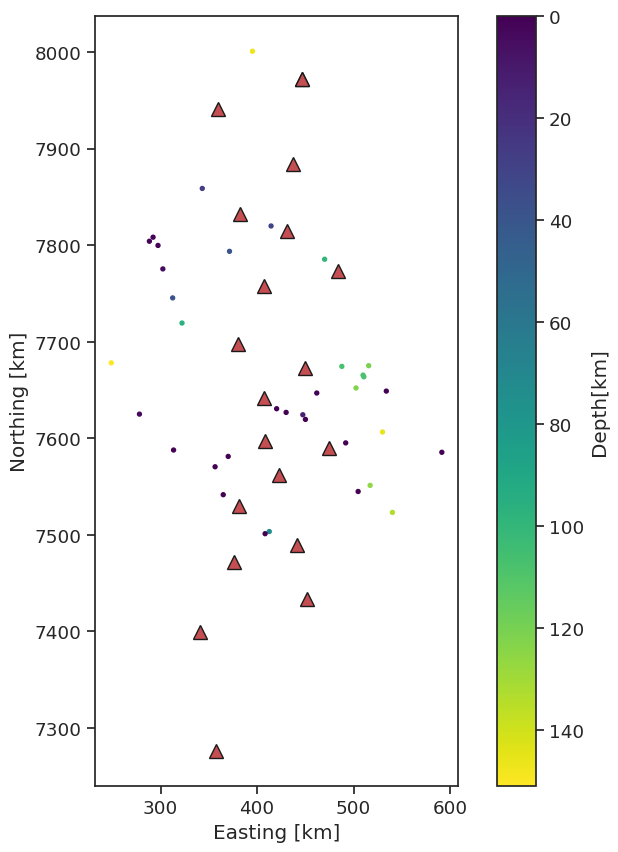

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

As a last check, we manually inspect some events. The code block below selects a random event and plots the waveforms, together with the P (solid black lines) and S (dashed black lines). The x axis denotes the time, the y axis the distance between station and estimated event location. Therefore, we should see roughly a hyperbolic moveout. Run the cell a few times to see a few example events.

Event information
time              2014-05-01T00:12:40.929
magnitude                             999
sigma_time                       0.423287
sigma_amp                               0
cov_time_amp                            0
gamma_score                     22.598363
number_picks                           23
number_p_picks                         14
number_s_picks                          9
event_index                            10
x(km)                           540.28391
y(km)                         7523.216113
z(km)                          133.849184
Name: 10, dtype: object


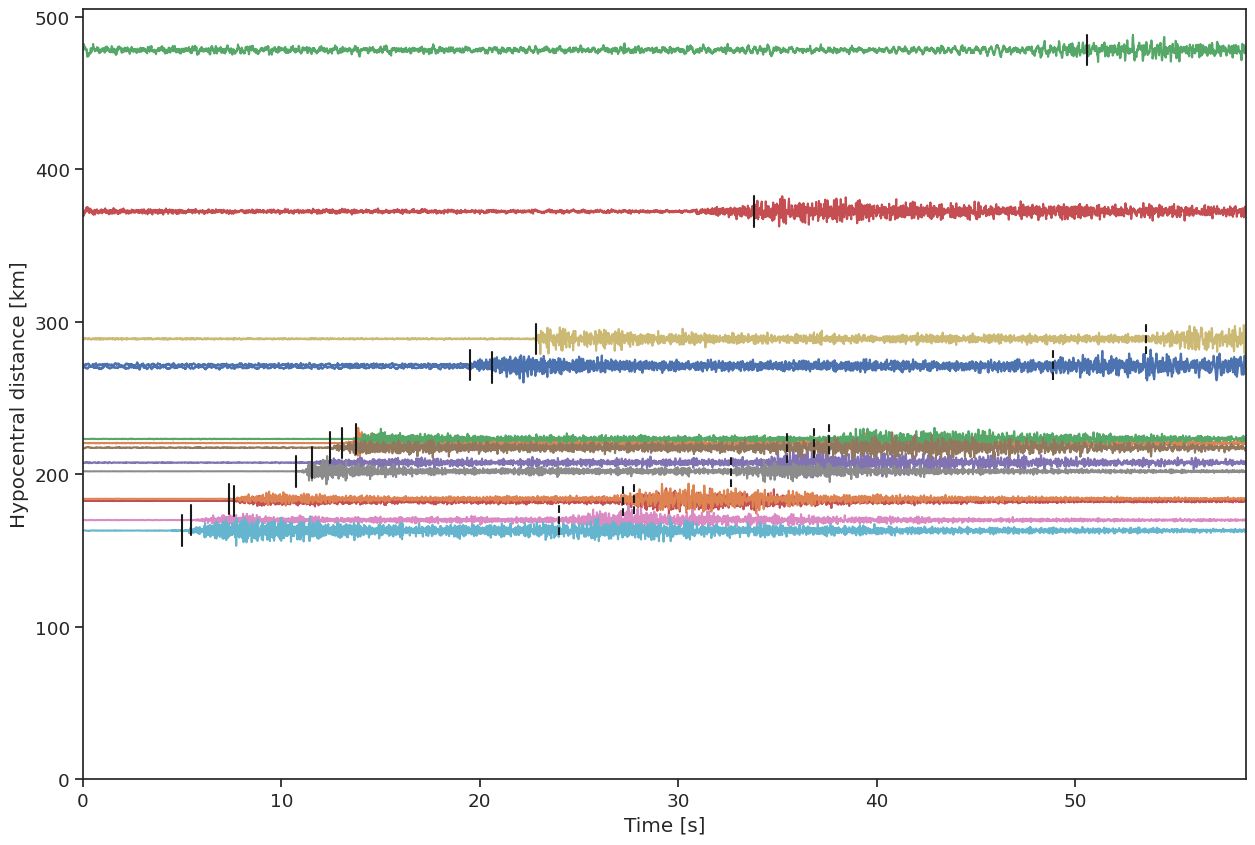

In [15]:
event_idx = np.random.randint(len(catalog))
event_picks = [picks[i] for i in assignments[assignments["event_index"] == event_idx]["pick_index"]]
event = catalog.iloc[event_idx]

first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

sub = obspy.Stream()

for station in np.unique([pick.trace_id for pick in event_picks]):
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    ax.plot(trace.times(), 10 * normed + y)
    
for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    x = pick.peak_time - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)
    
ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)

## Closing remarks

In this tutorial, we saw how to quickly generate an event catalog from raw seismic waveforms and their metadata using SeisBench and the GaMMA associator.

- We used a local coordinate projection for Chile for this tutorial. Depending on the region, you will need to choose a different projection.
- Both the picker and the model have several tuning parameters. We tuned these parameters loosely, but we would like to make the reader aware that these parameters can have strong influence on the number of picks and events, the number of false positives, and the runtime performance of the associator.
- While GaMMA outputs locations, these are only preliminary. It is highly recommended to further improve these using a more advances tool for localization.